In [1]:
import yfinance as yf
import datetime as dt
import pandas_datareader as pdr
import pandas as pd
import pandas_ta as pta
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import MaxPooling1D



## Descarga datos y creación dataset

In [2]:
sample_per = 400
stock = 'EURGBP=X'

end = dt.date.today()- dt.timedelta(days=2)
start = end - dt.timedelta(days=(sample_per))
interval = '1h'

In [3]:
database = yf.download(stock, start=start, end=end, interval=interval)

[*********************100%***********************]  1 of 1 completed


In [4]:
#EMA (200,50,20)
database['200ema'] = database['Adj Close'].ewm(span=200).mean()
database['50ema'] = database['Adj Close'].ewm(span=50, adjust=False).mean()
database['20ema'] = database['Adj Close'].ewm(span=20, adjust=False).mean()

In [5]:
database.head()

,Open,High,Low,Close,Adj Close,Volume,200ema,50ema,20ema
2020-07-27 00:00:00+01:00,0.91079,0.91103,0.9101,0.91047,0.91047,0,0.910470,0.910470,0.910470
2020-07-27 01:00:00+01:00,0.91045,0.91244,0.9101,0.91188,0.91188,0,0.911179,0.910525,0.910604
2020-07-27 02:00:00+01:00,0.91193,0.91200,0.9109,0.91128,0.91128,0,0.911213,0.910555,0.910669
2020-07-27 03:00:00+01:00,0.91135,0.91170,0.9105,0.91141,0.91141,0,0.911263,0.910588,0.910739
2020-07-27 04:00:00+01:00,0.91145,0.91206,0.9112,0.91181,0.91181,0,0.911374,0.910636,0.910841


In [6]:
data = database.copy()

data['Adj Close shi'] = data['Adj Close'].shift(-1)

data = data[['Adj Close shi','200ema','50ema','20ema']]

data.dropna(inplace=True)


data

,Adj Close shi,200ema,50ema,20ema
2020-07-27 00:00:00+01:00,0.91188,0.910470,0.910470,0.910470
2020-07-27 01:00:00+01:00,0.91128,0.911179,0.910525,0.910604
2020-07-27 02:00:00+01:00,0.91141,0.911213,0.910555,0.910669
2020-07-27 03:00:00+01:00,0.91181,0.911263,0.910588,0.910739
2020-07-27 04:00:00+01:00,0.91173,0.911374,0.910636,0.910841
...,...,...,...,...
2021-08-27 17:00:00+01:00,0.85672,0.855319,0.857030,0.857309
2021-08-27 18:00:00+01:00,0.85663,0.855332,0.857018,0.857253
2021-08-27 19:00:00+01:00,0.85703,0.855345,0.857003,0.857194
2021-08-27 20:00:00+01:00,0.85625,0.855362,0.857004,0.857178


## Preparacion datos para el LSTM

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6756 entries, 2020-07-27 00:00:00+01:00 to 2021-08-27 21:00:00+01:00
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Adj Close shi  6756 non-null   float64
 1   200ema         6756 non-null   float64
 2   50ema          6756 non-null   float64
 3   20ema          6756 non-null   float64
dtypes: float64(4)
memory usage: 263.9 KB


In [8]:
#Escalamos los valores con un MinMaxScaler
values = data.values

scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)

values = scaled


#Dividimos los datos entre train y test
train, val = train_test_split(values, test_size=0.2, shuffle=False)

#Dividimos datos validation entre validation y test
val, test = train_test_split(val, test_size=0.5, shuffle=False)

#Separamos los inputs de los outputs
train_X, train_y = train[:, 1:], train[:,0]
val_X, val_y = val[:, 1:], val[:,0]
test_X, test_y = test[:, 1:], test[:, 0]


#Generamos el reshape para poder incluir los valores en el modelo LSTM
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)

(5404, 1, 3) (5404,) (676, 1, 3) (676,) (676, 1, 3) (676,)


## Creamos el modelo

In [9]:
#Generamos arquitectura del modelo
model = Sequential()

model.add(LSTM(64,  return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))

model.add(LSTM(128, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(256, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(512, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(1024, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam')

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 64)             17408     
_________________________________________________________________
dropout (Dropout)            (None, 1, 64)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 128)            98816     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 128)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 256)            394240    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1, 256)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 512)            1

In [11]:
#Entrenamos el modelo
history = model.fit(train_X, train_y, epochs=15, batch_size = train_X.shape[0], validation_data=(val_X, val_y), verbose=1, shuffle=False)

Epoch 1/15
1/1 [==============================] - 8s 8s/step - loss: 0.2481 - val_loss: 0.5134
Epoch 2/15
1/1 [==============================] - 1s 1s/step - loss: 0.2480 - val_loss: 0.5111
Epoch 3/15
1/1 [==============================] - 1s 1s/step - loss: 0.2480 - val_loss: 0.5084
Epoch 4/15
1/1 [==============================] - 1s 1s/step - loss: 0.2479 - val_loss: 0.5056
Epoch 5/15
1/1 [==============================] - 1s 1s/step - loss: 0.2478 - val_loss: 0.5031
Epoch 6/15
1/1 [==============================] - 1s 1s/step - loss: 0.2477 - val_loss: 0.5008
Epoch 7/15
1/1 [==============================] - 1s 1s/step - loss: 0.2475 - val_loss: 0.4990
Epoch 8/15
1/1 [==============================] - 1s 1s/step - loss: 0.2473 - val_loss: 0.4976
Epoch 9/15
1/1 [==============================] - 1s 1s/step - loss: 0.2468 - val_loss: 0.4967
Epoch 10/15
1/1 [==============================] - 1s 1s/step - loss: 0.2462 - val_loss: 0.4960
Epoch 11/15
1/1 [==============================] 

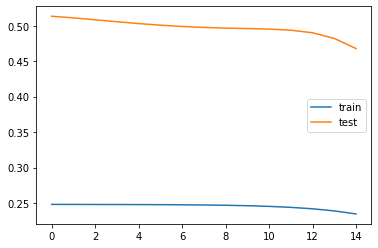

In [12]:
#Generamos plot con los resultados
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## Resultados con valores de test

In [13]:
# make a prediction
yhat = model.predict(test_X)

In [14]:
yhat_re = yhat.reshape((yhat.shape[0], yhat.shape[1]))

test_X_re = test_X.reshape((test_X.shape[0], test_X.shape[2]))

inv_yhat = np.concatenate((yhat_re, test_X_re), axis=1)

inv_yhat = scaler.inverse_transform(inv_yhat)

inv_yhat = inv_yhat[:,0]

In [15]:
test_y_re = test_y.reshape((len(test_y), 1))

inv_y = np.concatenate((test_y_re, test_X_re), axis=1)

inv_y = scaler.inverse_transform(inv_y)

inv_y = inv_y[:,0]

In [16]:
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.032


In [17]:
res = pd.DataFrame({'yhat':inv_yhat, 'y':inv_y})

res['yhat_log'] = res['yhat'].pct_change()
res['y_log'] = res['y'].pct_change()

res['res'] = res['yhat_log']*res['y_log']

lista =[]
for index, row in res.iterrows():
    if row['res'] > 0:
        lista.append(1)
    else:
        lista.append(-1)

serie = pd.Series(lista, index = res.index)

res['Up_Down'] = serie

res['Up_Down'].value_counts()

-1    351
 1    325
Name: Up_Down, dtype: int64

## Resultados con todos los valores

In [18]:
values_X, values_y = values[:, 1:], values[:,0]

values_X = values_X.reshape((values_X.shape[0], 1, values_X.shape[1]))

In [19]:
# make a prediction
yhat = model.predict(values_X)

In [20]:
yhat_re = yhat.reshape((yhat.shape[0], yhat.shape[1]))

values_X_re = values_X.reshape((values_X.shape[0], values_X.shape[2]))

inv_yhat = np.concatenate((yhat_re, values_X_re), axis=1)

inv_yhat = scaler.inverse_transform(inv_yhat)

inv_yhat = inv_yhat[:,0]

In [21]:
values_y_re = values_y.reshape((len(values_y), 1))

inv_y = np.concatenate((values_y_re, values_X_re), axis=1)

inv_y = scaler.inverse_transform(inv_y)

inv_y = inv_y[:,0]

In [22]:
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.022


In [23]:
res = pd.DataFrame({'yhat':inv_yhat, 'y':inv_y})

res['yhat_log'] = res['yhat'].pct_change()
res['y_log'] = res['y'].pct_change()

res['res'] = res['yhat_log']*res['y_log']

lista =[]
for index, row in res.iterrows():
    if row['res'] > 0:
        lista.append(1)
    else:
        lista.append(-1)

serie = pd.Series(lista, index = res.index)

res['Up_Down'] = serie

print(res['Up_Down'].value_counts())
print()
per = res['Up_Down'].value_counts()[1]/(res['Up_Down'].value_counts()[1]+res['Up_Down'].value_counts()[-1])
print(f'% acierto: {per}')

-1    3535
 1    3221
Name: Up_Down, dtype: int64

% acierto: 0.47676139727649497
